In [12]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold,KFold
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve, auc,precision_recall_curve
from sklearn.metrics import classification_report
import itertools
from scipy import interp

from bayes_opt import BayesianOptimization
from sklearn.impute import SimpleImputer
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

In [13]:
%%time
# 加载数据集  已初步剔除了一些无效特征
folder_path = './input/'
train = pd.read_csv(f'{folder_path}train.csv')
test_all = pd.read_csv(f'{folder_path}test.csv') # 包含标签hospital_death
test = test_all.drop(['hospital_death'],axis=1)
print("train shape:",train.shape)
print("test_all shape",test_all.shape)
print("test shape",test.shape)


train shape: (73370, 74)
test_all shape (18343, 74)
test shape (18343, 73)
CPU times: user 439 ms, sys: 75 ms, total: 514 ms
Wall time: 523 ms


In [14]:
# 通过null importance 选出来的有效特征55个
uesful_features = [
 'age',
 'bmi',
 'elective_surgery',
 'gender',
 'icu_admit_source',
 'icu_id',
 'pre_icu_los_days',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'apache_post_operative',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_verbal_apache',
 'intubated_apache',
 'map_apache',
 'resprate_apache',
 'temp_apache',
 'ventilated_apache',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_resprate_max',
 'd1_resprate_min',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_sysbp_noninvasive_max',
 'd1_sysbp_noninvasive_min',
 'd1_temp_max',
 'd1_temp_min',
 'h1_diasbp_min',
 'h1_diasbp_noninvasive_min',
 'h1_heartrate_min',
 'h1_mbp_max',
 'h1_mbp_min',
 'h1_mbp_noninvasive_min',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_spo2_max',
 'h1_spo2_min',
 'h1_sysbp_max',
 'h1_sysbp_min',
 'h1_sysbp_noninvasive_min',
 'd1_glucose_min',
 'd1_potassium_max',
 'd1_potassium_min',
 'apache_4a_hospital_death_prob',
 'apache_4a_icu_death_prob',
 'diabetes_mellitus']
len(uesful_features)

55

In [15]:
cols_to_drop = [col for col in train.columns if col not in uesful_features]
cols_to_drop.remove('hospital_death')

print("清理前 train shape:", train.shape)
print("清理前 test  shape:", test.shape)
print("\n")
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)
print("清理后 train shape:", train.shape)
print("清理后 test  shape:", test.shape)

清理前 train shape: (73370, 74)
清理前 test  shape: (18343, 73)


清理后 train shape: (73370, 56)
清理后 test  shape: (18343, 55)


In [16]:
# # LabelEncoder
# for col in tqdm_notebook(train.columns):
#     if train[col].dtype == "object":
#         encoder = LabelEncoder()
#         encoder.fit(list(train[col].values) + list(test[col].values))
#         train[col] = encoder.transform(list(train[col].values))
#         test[col] = encoder.transform(list(test[col].values))
        
# train = train.reset_index() # 重置索引
# test = test.reset_index()

In [17]:
# one_hot
catColnums = train.select_dtypes(include=['object']).columns
train = pd.get_dummies(train, columns= catColnums)
test = pd.get_dummies(test, columns= catColnums)

# 填补缺失值 并进行归一化 将第8行注释
验证集 0.8830


测试集：
roc score      : 0.8831
accuracy score : 0.9268
recall score   : 0.3215
f1 score       : 0.4312
precision score: 0.6542

In [18]:

# from sklearn.preprocessing import StandardScaler
# # 填充缺失值
# imp = SimpleImputer(strategy='median')
# new_train = pd.DataFrame(imp.fit_transform(train),columns=train.columns)
# new_test = pd.DataFrame(imp.fit_transform(test),columns=test.columns)

# train_df = new_train.copy()
# test_df = new_test.copy()
# # 进行归一化
# train_df = pd.DataFrame(StandardScaler().fit_transform(train_df),columns=train_df.columns)
# train_df['hospital_death'] = new_train['hospital_death']
# test_df = pd.DataFrame(StandardScaler().fit_transform(test_df),columns=test_df.columns)


# 不填补缺失值 将第七行注释掉
验证集AUC：0.8827

测试集
roc score      : 0.8842
accuracy score : 0.9274
recall score   : 0.3241
f1 score       : 0.4353
precision score: 0.6628

加上 max-death
验证集AUC：0.8862
测试集
roc score      : 0.8867
accuracy score : 0.9282
recall score   : 0.3310
f1 score       : 0.4431
precision score: 0.6701

In [19]:
train_df = train
test_df = test

In [20]:
features = list(train_df)
features.remove('hospital_death')
target = 'hospital_death'

In [21]:
bayesian_tr_idx, bayesian_val_idx = train_test_split(train_df, test_size = 0.2, random_state = 42, stratify = train_df[target])
bayesian_tr_idx = bayesian_tr_idx.index
bayesian_val_idx = bayesian_val_idx.index

In [22]:
#black box LGBM 
def LGB_bayesian(
    learning_rate,
    num_leaves, 
    bagging_fraction,
    feature_fraction,
    min_child_weight, 
    min_data_in_leaf,
    max_depth,
    reg_alpha,
    reg_lambda
     ):
    
    # LightGBM expects next three parameters need to be integer. 
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int
    

    param = {
              'num_leaves': num_leaves, 
              'min_data_in_leaf': min_data_in_leaf,
              'min_child_weight': min_child_weight,
              'bagging_fraction' : bagging_fraction,
              'feature_fraction' : feature_fraction,
              'learning_rate' : learning_rate,
              'max_depth': max_depth,
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda,
    
               'metric': 'auc',
               'verbose': -1,
               'objective': 'binary',
#                'max_depth': -1,
               'boosting_type': 'gbdt',
               'random_state': 66,
               'n_jobs': 7,
               'save_binary': True,
               'num_iterations': 20000,
               'early_stopping_round': 200
    }    
    
    oof = np.zeros(len(train_df))
    trn_data= lgb.Dataset(train_df.iloc[bayesian_tr_idx][features].values, label=train_df.iloc[bayesian_tr_idx][target].values)
    val_data= lgb.Dataset(train_df.iloc[bayesian_val_idx][features].values, label=train_df.iloc[bayesian_val_idx][target].values)

    clf = lgb.train(param, trn_data,  valid_sets = [trn_data, val_data], verbose_eval=0, early_stopping_rounds = 200)
    
    oof[bayesian_val_idx]  = clf.predict(train_df.iloc[bayesian_val_idx][features].values, num_iteration=clf.best_iteration)  
    
    score = roc_auc_score(train_df.iloc[bayesian_val_idx][target].values, oof[bayesian_val_idx])
    score = 0
    return score

In [23]:
# Bounded region of parameter space
bounds_LGB = {
    'num_leaves': (31, 500), 
    'min_data_in_leaf': (20, 200),
    'bagging_fraction' : (0.1, 0.9),
    'feature_fraction' : (0.1, 0.9),
    'learning_rate': (0.01, 0.3),
    'min_child_weight': (0.00001, 0.01),   
    'reg_alpha': (0, 1), 
    'reg_lambda': (0, 1),
    'max_depth':(-1,50),
}

In [24]:
LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=42)

In [25]:
print(LGB_BO.space.keys)

['bagging_fraction', 'feature_fraction', 'learning_rate', 'max_depth', 'min_child_weight', 'min_data_in_leaf', 'num_leaves', 'reg_alpha', 'reg_lambda']


In [26]:
init_points = 10
n_iter = 15

In [27]:
print('-' * 130)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | featur... | learni... | max_depth | min_ch... | min_da... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.0      |  0.3996   |  0.8606   |  0.2223   |  29.53    |  0.001569 |  48.08    |  58.24    |  0.8662   |  0.6011   |
|  2        |  0.0      |  0.6665   |  0.1165   |  0.2913   |  41.45    |  0.002131 |  52.73    |  117.0    |  0.3042   |  0.5248   |
|  3        |  0.0      |  0.4456   |  0.333    |  0.1874   |  6.114    |  0.002929 |  85.95    |  244.9    |  0.7852   |  0.1997   |
|  4        |  0.0      |  0.5114   |  0.5739   |  0.02347  |  29.98    |  0.001714 |  31.71    |  476.0    |  0.9656   |  0.8084   |
|  5        |  0.0      |  0.3437   |  0.1781   |  0.2084   |  21

In [28]:
LGB_BO.max['target']

0.0

In [29]:
LGB_BO.max['params']

{'bagging_fraction': 0.39963209507789,
 'feature_fraction': 0.8605714451279329,
 'learning_rate': 0.22227824312530747,
 'max_depth': 29.531582694048865,
 'min_child_weight': 0.001568626218019941,
 'min_data_in_leaf': 48.07901366051648,
 'num_leaves': 58.24121410688555,
 'reg_alpha': 0.8661761457749352,
 'reg_lambda': 0.6011150117432088}

In [30]:
# Confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [31]:
#LGB + best hyperparameters¶
param_lgb = {
        'min_data_in_leaf': int(LGB_BO.max['params']['min_data_in_leaf']), 
        'num_leaves': int(LGB_BO.max['params']['num_leaves']), 
        'learning_rate': LGB_BO.max['params']['learning_rate'],
        'min_child_weight': LGB_BO.max['params']['min_child_weight'],
        'bagging_fraction': LGB_BO.max['params']['bagging_fraction'], 
        'feature_fraction': LGB_BO.max['params']['feature_fraction'],
        'reg_lambda': LGB_BO.max['params']['reg_lambda'],
        'reg_alpha': LGB_BO.max['params']['reg_alpha'],
        'max_depth': int(LGB_BO.max['params']['max_depth']), 
        'metric': 'auc',
        'verbose': -1,
        'objective': 'binary',
#         'max_depth': -1,
        'boosting_type': 'gbdt',
        'random_state': 66,
        'n_jobs': 7,
        'save_binary': True,
        'num_iterations': 20000,
        'early_stopping_round': 200
    }


fold 1
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.994936	valid_1's auc: 0.880089
[200]	training's auc: 0.99992	valid_1's auc: 0.87813
Early stopping, best iteration is:
[32]	training's auc: 0.956278	valid_1's auc: 0.883416

fold 2
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.994801	valid_1's auc: 0.886602
[200]	training's auc: 0.999974	valid_1's auc: 0.883842
Early stopping, best iteration is:
[45]	training's auc: 0.970229	valid_1's auc: 0.890744

fold 3
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.994555	valid_1's auc: 0.887017
[200]	training's auc: 0.999899	valid_1's auc: 0.88494
Early stopping, best iteration is:
[27]	training's auc: 0.947139	valid_1's auc: 0.891999

fold 4
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.994527	valid_1's auc: 0.882787
[200]	training's auc: 0.999949	valid_1's auc: 0.881132
Early stopping, 

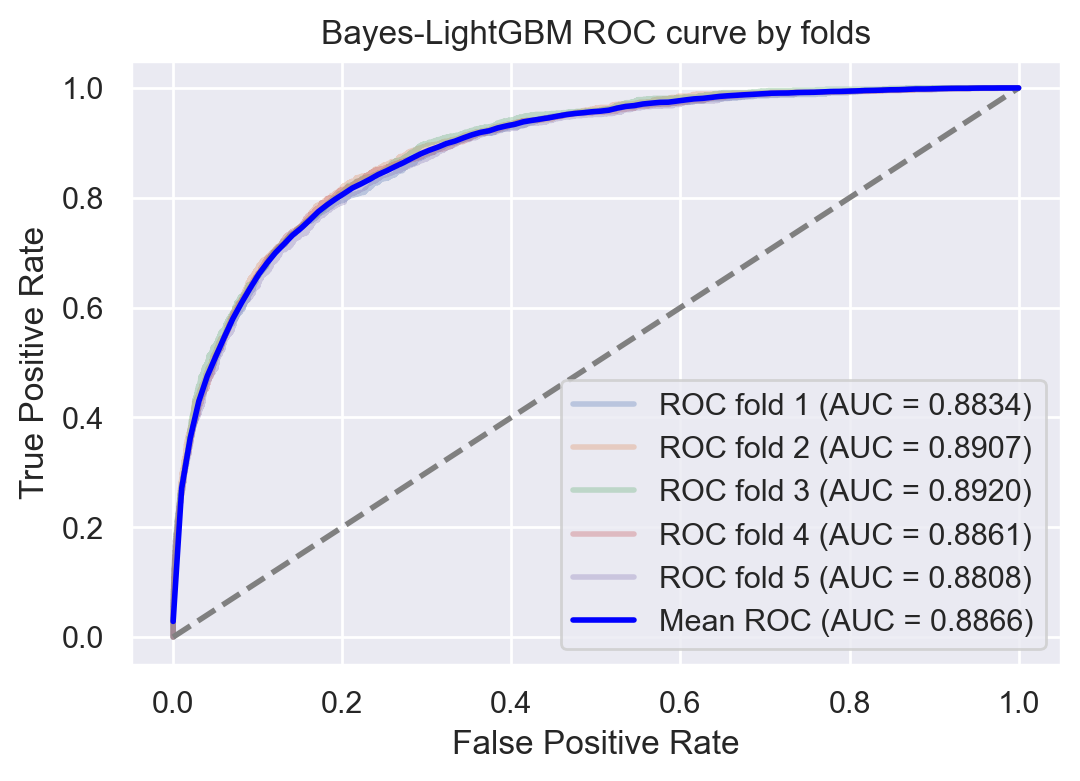

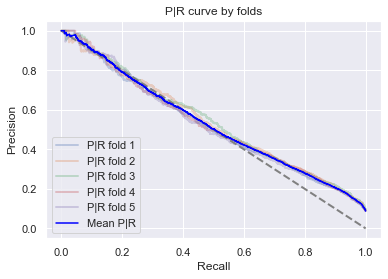

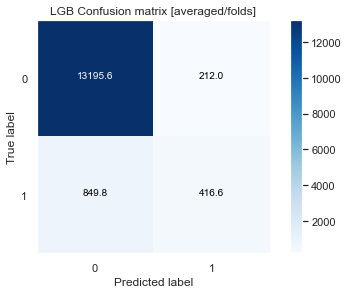

In [32]:
plt.rcParams["axes.grid"] = True
plt.figure(dpi=200)
nfold = 5
skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=42)

oof = np.zeros(len(train_df))
mean_fpr = np.linspace(0,1,100)
cms= []
tprs = []
aucs = []
y_real = []
y_proba = []
recalls = []
roc_aucs = []
f1_scores = []
accuracies = []
precisions = []
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

best_model = None
best_score = 0

i = 1
for train_idx, valid_idx in skf.split(train_df, train_df.hospital_death.values):
    print("\nfold {}".format(i))
    trn_data = lgb.Dataset(train_df.iloc[train_idx][features].values,
                                   label=train_df.iloc[train_idx][target].values
                                   )
    val_data = lgb.Dataset(train_df.iloc[valid_idx][features].values,
                                   label=train_df.iloc[valid_idx][target].values
                                   )   
    
    clf = lgb.train(param_lgb, trn_data, num_boost_round = 500, valid_sets = [trn_data, val_data], verbose_eval = 100, early_stopping_rounds = 100)
    oof[valid_idx] = clf.predict(train_df.iloc[valid_idx][features].values) 
    
    predictions += clf.predict(test_df[features]) / nfold
    
    score = roc_auc_score(train_df.iloc[valid_idx][target].values, oof[valid_idx])
    if (best_score < score):
        best_score = score
        best_model = clf
        
    # Scores 
    roc_aucs.append(score)
    accuracies.append(accuracy_score(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    recalls.append(recall_score(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    precisions.append(precision_score(train_df.iloc[valid_idx][target].values ,oof[valid_idx].round()))
    f1_scores.append(f1_score(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    # Roc curve by folds
    f = plt.figure(1)
    fpr, tpr, t = roc_curve(train_df.iloc[valid_idx][target].values, oof[valid_idx])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (i,roc_auc))
    
    # Precion recall by folds
    g = plt.figure(2)
    precision, recall, _ = precision_recall_curve(train_df.iloc[valid_idx][target].values, oof[valid_idx])
    y_real.append(train_df.iloc[valid_idx][target].values)
    y_proba.append(oof[valid_idx])
    plt.plot(recall, precision, lw=2, alpha=0.3, label='P|R fold %d' % (i))  
    
    i= i+1
    
    # Confusion matrix by folds
    cms.append(confusion_matrix(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    # Features imp
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = nfold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

# Metrics
print(
        '\nCV roc score        : {0:.4f}, std: {1:.4f}.'.format(np.mean(roc_aucs), np.std(roc_aucs)),
        '\nCV accuracy score   : {0:.4f}, std: {1:.4f}.'.format(np.mean(accuracies), np.std(accuracies)),
        '\nCV recall score     : {0:.4f}, std: {1:.4f}.'.format(np.mean(recalls), np.std(recalls)),
        '\nCV precision score  : {0:.4f}, std: {1:.4f}.'.format(np.mean(precisions), np.std(precisions)),
        '\nCV f1 score         : {0:.4f}, std: {1:.4f}.'.format(np.mean(f1_scores), np.std(f1_scores))
)

#ROC 
f = plt.figure(1)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'grey')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.4f)' % (np.mean(roc_aucs)),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bayes-LightGBM ROC curve by folds')
plt.legend(loc="lower right")

# PR plt
g = plt.figure(2)
plt.plot([0,1],[1,0],linestyle = '--',lw = 2,color = 'grey')
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
plt.plot(recall, precision, color='blue',
         label=r'Mean P|R')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('P|R curve by folds')
plt.legend(loc="lower left")

# Confusion maxtrix & metrics
plt.rcParams["axes.grid"] = False
cm = np.average(cms, axis=0)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title= 'LGB Confusion matrix [averaged/folds]')
plt.show()

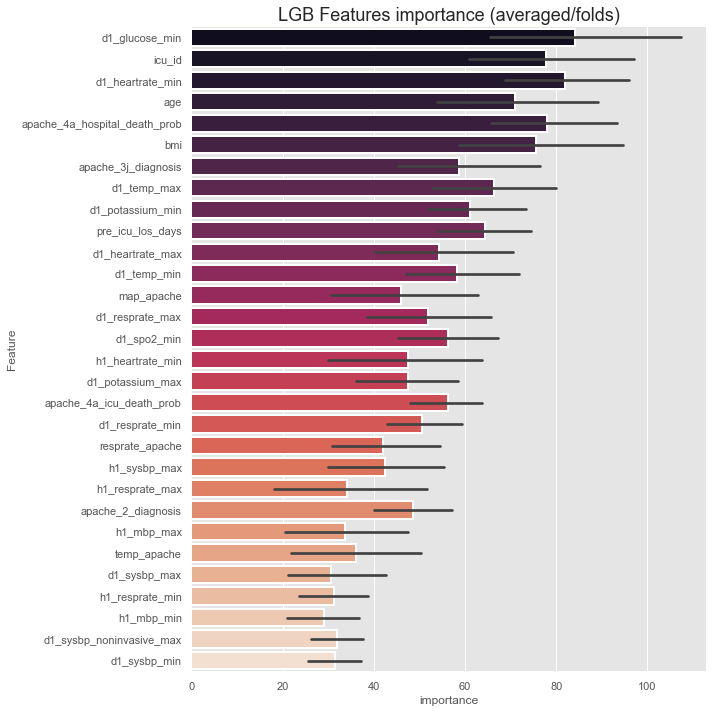

In [33]:
plt.style.use('ggplot')
cols = (feature_importance_df[["Feature", "importance"]]
    .groupby("Feature")
    .mean()
    .sort_values(by="importance", ascending=False)[:30].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(10,10))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False),
        edgecolor=('white'), linewidth=2, palette="rocket")
plt.title('LGB Features importance (averaged/folds)', fontsize=18)
plt.tight_layout()

In [34]:
y_pred = best_model.predict(test_df)

In [35]:
print("roc score      : {0:.4f}".format(roc_auc_score(test_all['hospital_death'], y_pred)))
print("accuracy score : {0:.4f}".format(accuracy_score(test_all['hospital_death'], y_pred.round())))
print("recall score   : {0:.4f}".format(recall_score(test_all['hospital_death'], y_pred.round())))
print("f1 score       : {0:.4f}".format(f1_score(test_all['hospital_death'], y_pred.round())))
print("precision score: {0:.4f}".format(precision_score(test_all['hospital_death'], y_pred.round())))

roc score      : 0.8888
accuracy score : 0.9284
recall score   : 0.3222
f1 score       : 0.4370
precision score: 0.6791


In [36]:
clf.params

{'min_data_in_leaf': 48,
 'num_leaves': 58,
 'learning_rate': 0.22227824312530747,
 'min_child_weight': 0.001568626218019941,
 'bagging_fraction': 0.39963209507789,
 'feature_fraction': 0.8605714451279329,
 'reg_lambda': 0.6011150117432088,
 'reg_alpha': 0.8661761457749352,
 'max_depth': 29,
 'metric': 'auc',
 'verbose': -1,
 'objective': 'binary',
 'boosting_type': 'gbdt',
 'random_state': 66,
 'n_jobs': 7,
 'save_binary': True,
 'num_iterations': 20000,
 'early_stopping_round': 200}

In [ ]:
import joblib
joblib.dump(best_model, "./model/bayes_LGB_best_model.pkl") # 保存模型